<a href="https://colab.research.google.com/github/trlongsama/NLP_Project/blob/master/LSTM_image_captioning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Captioning with Conditioned LSTM Generators

In [ ]:
import os
from collections import defaultdict
import numpy as np
import PIL
from matplotlib import pyplot as plt
%matplotlib inline

import keras
from keras import Sequential, Model
from keras.layers import Embedding, LSTM, Dense, Input, Bidirectional, RepeatVector, Concatenate, Activation
from keras.activations import softmax
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences

from keras.applications.inception_v3 import InceptionV3

from keras.optimizers import Adam

from google.colab import drive

Using TensorFlow backend.


### Access to the flickr8k data

We will use the flickr8k data set, described here in more detail: 

> M. Hodosh, P. Young and J. Hockenmaier (2013) "Framing Image Description as a Ranking Task: Data, Models and Evaluation Metrics", Journal of Artificial Intelligence Research, Volume 47, pages 853-899 http://www.jair.org/papers/paper3994.html when discussing our results



In [ ]:
my_data_dir="datalocation"

In [ ]:
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


Please look at the 'Files' tab on the left side and make sure you can see the 'hw5_data' folder that you have in your GDrive.

The files Flickr_8k.trainImages.txt Flickr_8k.devImages.txt Flickr_8k.testImages.txt, contain a list of training, development, and test images, respectively. Let's load these lists. 

In [ ]:
def load_image_list(filename):
    with open(filename,'r') as image_list_f: 
        return [line.strip() for line in image_list_f]    

In [ ]:
train_list = load_image_list('/content/gdrive/My Drive/'+my_data_dir+'/Flickr_8k.trainImages.txt')
dev_list = load_image_list('/content/gdrive/My Drive/'+my_data_dir+'/Flickr_8k.devImages.txt')
test_list = load_image_list('/content/gdrive/My Drive/'+my_data_dir+'/Flickr_8k.testImages.txt')

In [ ]:
len(train_list), len(dev_list), len(test_list)

(6000, 1000, 1000)

Each entry is an image filename.

In [ ]:
dev_list[20]

'3693961165_9d6c333d5b.jpg'

In [ ]:
IMG_PATH = '/content/gdrive/My Drive/'+my_data_dir+"/Flickr8k_Dataset/"

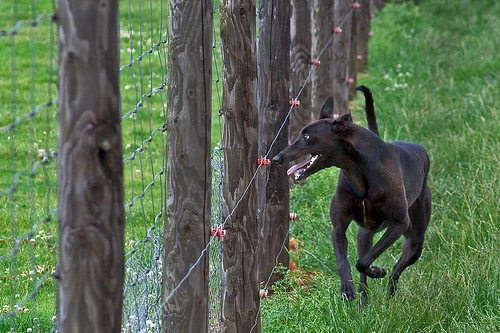

In [ ]:
image = PIL.Image.open(os.path.join(IMG_PATH, dev_list[20]))
image

For encoder, use an off-the-shelf pre-trained image encoder, the Inception V3 network. The model is a version of a convolution neural network for object detection. Here is more detail about this model (not required for this project): 

> Szegedy, C., Vanhoucke, V., Ioffe, S., Shlens, J., & Wojna, Z. (2016). Rethinking the inception architecture for computer vision. In Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 2818-2826).
> https://www.cv-foundation.org/openaccess/content_cvpr_2016/html/Szegedy_Rethinking_the_Inception_CVPR_2016_paper.html

Resize the image to be 299x299 pixels, with 3 color channels (RGB). The individual RGB values need to range between 0 and 1.0. The flickr images don't fit. 

In [ ]:
np.asarray(image).shape

(333, 500, 3)

The values range from 0 to 255. 

In [ ]:
np.asarray(image)

array([[[118, 161,  89],
        [120, 164,  89],
        [111, 157,  82],
        ...,
        [ 68, 106,  65],
        [ 64, 102,  61],
        [ 65, 104,  60]],

       [[125, 168,  96],
        [121, 164,  92],
        [119, 165,  90],
        ...,
        [ 72, 115,  72],
        [ 65, 108,  65],
        [ 72, 115,  70]],

       [[129, 175, 102],
        [123, 169,  96],
        [115, 161,  88],
        ...,
        [ 88, 129,  87],
        [ 75, 116,  72],
        [ 75, 116,  72]],

       ...,

       [[ 41, 118,  46],
        [ 36, 113,  41],
        [ 45, 111,  49],
        ...,
        [ 23,  77,  15],
        [ 60, 114,  62],
        [ 19,  59,   0]],

       [[100, 158,  97],
        [ 38, 100,  37],
        [ 46, 117,  51],
        ...,
        [ 25,  54,   8],
        [ 88, 112,  76],
        [ 65, 106,  48]],

       [[ 89, 148,  84],
        [ 44, 112,  35],
        [ 71, 130,  72],
        ...,
        [152, 188, 142],
        [113, 151, 110],
        [ 94, 138,  75]]

We can use PIL to resize the image and then divide every value by 255. 

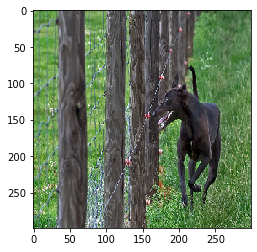

In [ ]:
new_image = np.asarray(image.resize((299,299))) / 255.0
plt.imshow(new_image)

In [ ]:
new_image.shape

(299, 299, 3)

Let's put this all in a function for convenience. 

In [ ]:
def get_image(image_name):
    image = PIL.Image.open(os.path.join(IMG_PATH, image_name))
    return np.asarray(image.resize((299,299))) / 255.0                     

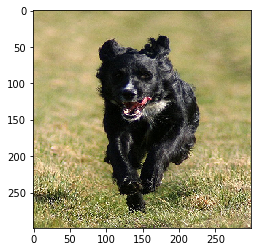

In [ ]:
plt.imshow(get_image(dev_list[25]))

In [ ]:
img_model = InceptionV3(weights='imagenet') # This will download the weight files for you and might take a while.














96116736/96112376 [==============================] - 7s 0us/step


In [ ]:
img_model.summary() # this is quite a complex model. 

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 149, 149, 32) 0           batch_normalization_1[0][0]      
_______________________________________________________________________________________

This is a prediction model,so the output is typically a softmax-activated vector representing 1000 possible object types. Because we are interested in an encoded representation of the image we are just going to use the second-to-last layer as a source of image encodings. Each image will be encoded as a vector of size 2048. 

In [ ]:
new_input = img_model.input
new_output = img_model.layers[-2].output
img_encoder = Model(new_input, new_output) # This is the final Keras image encoder model we will use.

The encoder. 

In [ ]:
encoded_image = img_encoder.predict(np.array([new_image]))

In [ ]:
encoded_image

array([[0.51165044, 0.44918403, 0.05747698, ..., 0.76968277, 0.37723544,
        0.5700188 ]], dtype=float32)

In [ ]:
def img_generator(img_list):
    for img_name in img_list:
      image = get_image(img_name)
      arr_image = np.array([image])
      yield arr_image

encode all images 

In [ ]:
enc_train = img_encoder.predict_generator(img_generator(train_list), steps=len(train_list), verbose=1)

6000/6000 [==============================] - 2710s 452ms/step


In [ ]:
enc_train[11]

array([0.31002453, 0.81883526, 0.5969685 , ..., 1.2087553 , 0.15127039,
       0.15575749], dtype=float32)

In [ ]:
enc_dev = img_encoder.predict_generator(img_generator(dev_list), steps=len(dev_list), verbose=1)

1000/1000 [==============================] - 524s 524ms/step


In [ ]:
enc_test = img_encoder.predict_generator(img_generator(test_list), steps=len(test_list), verbose=1)

1000/1000 [==============================] - 528s 528ms/step


It's a good idea to save the resulting matrices, so we do not have to run the encoder again. 

In [ ]:
np.save("gdrive/My Drive/"+my_data_dir+"/outputs/encoded_images_train.npy", enc_train)
np.save("gdrive/My Drive/"+my_data_dir+"/outputs/encoded_images_dev.npy", enc_dev)
np.save("gdrive/My Drive/"+my_data_dir+"/outputs/encoded_images_test.npy", enc_test)

### Reading image descriptions

In [ ]:
def read_image_descriptions(filename):    
    image_descriptions = defaultdict(list)    
    with open(filename) as file:
      for line in file.readlines():
        tk_line = line.split()
        key, val = tk_line[0].split('#')[0], [item.lower() for item in tk_line[1:]]
        #print(key, val)
        image_descriptions[key].append(['<START>']+val+['<END>'])
    #print(image_descriptions)
    return image_descriptions

In [ ]:
descriptions = read_image_descriptions("gdrive/My Drive/"+my_data_dir+"/Flickr8k.token.txt")

In [ ]:
print(descriptions[dev_list[0]])

[['<START>', 'the', 'boy', 'laying', 'face', 'down', 'on', 'a', 'skateboard', 'is', 'being', 'pushed', 'along', 'the', 'ground', 'by', 'another', 'boy', '.', '<END>'], ['<START>', 'two', 'girls', 'play', 'on', 'a', 'skateboard', 'in', 'a', 'courtyard', '.', '<END>'], ['<START>', 'two', 'people', 'play', 'on', 'a', 'long', 'skateboard', '.', '<END>'], ['<START>', 'two', 'small', 'children', 'in', 'red', 'shirts', 'playing', 'on', 'a', 'skateboard', '.', '<END>'], ['<START>', 'two', 'young', 'children', 'on', 'a', 'skateboard', 'going', 'across', 'a', 'sidewalk', '<END>']]


Running the previous cell should print:     
`[['<START>', 'the', 'boy', 'laying', 'face', 'down', 'on', 'a', 'skateboard', 'is', 'being', 'pushed', 'along', 'the', 'ground', 'by', 'another', 'boy', '.', '<END>'], ['<START>', 'two', 'girls', 'play', 'on', 'a', 'skateboard', 'in', 'a', 'courtyard', '.', '<END>'], ['<START>', 'two', 'people', 'play', 'on', 'a', 'long', 'skateboard', '.', '<END>'], ['<START>', 'two', 'small', 'children', 'in', 'red', 'shirts', 'playing', 'on', 'a', 'skateboard', '.', '<END>'], ['<START>', 'two', 'young', 'children', 'on', 'a', 'skateboard', 'going', 'across', 'a', 'sidewalk', '<END>']]
`    

### Creating Word Indices

Next, we need to create a lookup table from the **training** data mapping words to integer indices, so we can encode input 
and output sequences using numeric representations. 

In [ ]:
id_to_word = {}
word_to_id = {}
token_set = set()
for key, value in descriptions.items():
  for sub_lst in value:
    token_set.update(set(sub_lst))
token_lst = sorted(list(token_set))
for idx, token in enumerate(token_lst):
  id_to_word[idx]=token
  word_to_id[token] = idx

In [ ]:
word_to_id['dog'] # should print an integer

2309

In [ ]:
id_to_word[1985] # should print a token

'crucified'

The core idea here is that the Keras recurrent layers (including LSTM) create an "unrolled" RNN. Each time-step is represented as a different unit, but the weights for these units are shared. We are going to use the constant MAX_LEN to refer to the maximum length of a sequence, which turns out to be 40 words in this data set (including START and END).

In [ ]:
max(len(description) for image_id in train_list for description in descriptions[image_id])

40

Here is the model in Keras Keras. Using a Bidirectional LSTM, which encodes the sequence from both directions and then predicts the output. 


Employ an embedding layer for the input words. The weights are shared between all units of the unrolled LSTM. We will train these embeddings with the model. 

In [ ]:
MAX_LEN = 40
EMBEDDING_DIM=300
vocab_size = len(word_to_id)

# Text input
text_input = Input(shape=(MAX_LEN,))
embedding = Embedding(vocab_size, EMBEDDING_DIM, input_length=MAX_LEN)(text_input)
x = Bidirectional(LSTM(512, return_sequences=False))(embedding)
pred = Dense(vocab_size, activation='softmax')(x)
model = Model(inputs=[text_input],outputs=pred)
model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])

model.summary()



Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 40)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 40, 300)           2676000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 1024)              3330048   
_________________________________________________________________
dense_2 (Dense)              (None, 8920)              9143000   
Total params: 15,149,048
Trainable params: 15,149,048
Non-trainable params: 0
_________________________________________________________________


### Creating a Generator for the Training Data

In [1]:
def text_training_generator(batch_size=128):
    input = np.array([])
    output = np.array([])
    while 1:
      train_idx = 0
      descrip_idx = 0
      output_idx = 1
      while 1:
        cur_word = descriptions[train_list[train_idx]][descrip_idx][:output_idx]
        cur_input = [word_to_id[word] for word in cur_word]+[0]*(MAX_LEN-output_idx)
        output_word = descriptions[train_list[train_idx]][descrip_idx][output_idx]
        output_num = word_to_id[output_word]
        cur_output = [0 if i!=output_num else 1 for i in range(vocab_size)]
        #print(train_idx, descrip_idx, output_idx)
        #print(descriptions[train_list[train_idx]][descrip_idx], output_word)
        if len(input)>0:
          input = np.vstack((input, cur_input))
          output = np.vstack((output, cur_output))
        else:
          input = np.array([cur_input])
          output = np.array([cur_output])
        if output_idx == len(descriptions[train_list[train_idx]][descrip_idx])-1:
          output_idx = 0
          descrip_idx +=1
          if descrip_idx == len(descriptions[train_list[train_idx]]):
            descrip_idx = 0
            train_idx+=1
            if train_idx == len(train_list):
              break
        output_idx+=1
        if input.size >= batch_size*MAX_LEN:
          yield input, output
          input = np.array([])
          output = np.array([])

### Training the Model based on Keras


In [ ]:
batch_size = 128
generator = text_training_generator(batch_size)
steps = len(train_list) * MAX_LEN // batch_size 

In [ ]:
model.fit_generator(generator, steps_per_epoch=steps, verbose=True, epochs=10)

Epoch 1/10
1875/1875 [==============================] - 554s 296ms/step - loss: 4.2390 - acc: 0.2964
Epoch 2/10
1875/1875 [==============================] - 555s 296ms/step - loss: 3.6673 - acc: 0.3588
Epoch 3/10
1875/1875 [==============================] - 559s 298ms/step - loss: 3.4945 - acc: 0.3748
Epoch 4/10
1875/1875 [==============================] - 562s 300ms/step - loss: 3.4129 - acc: 0.3834
Epoch 5/10
1875/1875 [==============================] - 563s 300ms/step - loss: 3.3800 - acc: 0.3893
Epoch 6/10
1875/1875 [==============================] - 560s 299ms/step - loss: 3.3154 - acc: 0.3951
Epoch 7/10
1875/1875 [==============================] - 557s 297ms/step - loss: 3.3154 - acc: 0.3970
Epoch 8/10
1875/1875 [==============================] - 545s 291ms/step - loss: 3.2958 - acc: 0.3998
Epoch 9/10
1875/1875 [==============================] - 544s 290ms/step - loss: 3.2958 - acc: 0.4038
Epoch 10/10
1875/1875 [==============================] - 540s 288ms/step - loss: 3.3230 - a

In [ ]:
model.save_weights('gdrive/My Drive/hw5_data_rt/trained_model.h5')

In [ ]:
model = model.load_weights('gdrive/My Drive/hw5_data_rt/trained_model.h5')







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




In [ ]:
MAX_LEN = 40
EMBEDDING_DIM=300
IMAGE_ENC_DIM=300
vocab_size = len(word_to_id)

# Image input
img_input = Input(shape=(2048,))
img_enc = Dense(300, activation="relu") (img_input)
images = RepeatVector(MAX_LEN)(img_enc)

# Text input
text_input = Input(shape=(MAX_LEN,))
embedding = Embedding(vocab_size, EMBEDDING_DIM, input_length=MAX_LEN)(text_input)
x = Concatenate()([images,embedding])
y = Bidirectional(LSTM(256, return_sequences=False))(x) 
pred = Dense(vocab_size, activation='softmax')(y)
model = Model(inputs=[img_input,text_input],outputs=pred)
model.compile(loss='categorical_crossentropy', optimizer="RMSProp", metrics=['accuracy'])

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 300)          614700      input_3[0][0]                    
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 40)           0                                            
__________________________________________________________________________________________________
repeat_vector_2 (RepeatVector)  (None, 40, 300)      0           dense_3[0][0]                    
____________________________________________________________________________________________

In [ ]:
enc_train = np.load("gdrive/My Drive/"+my_data_dir+"/outputs/encoded_images_train.npy")
enc_dev = np.load("gdrive/My Drive/"+my_data_dir+"/outputs/encoded_images_dev.npy")

In [ ]:
print(enc_train.shape)

(6000, 2048)


In [ ]:
def training_generator(batch_size=128):
    input = np.array([])
    input_img = np.array([])
    output = np.array([])
    while 1:
      train_idx = 0
      descrip_idx = 0
      output_idx = 1
      while 1:
        cur_word = descriptions[train_list[train_idx]][descrip_idx][:output_idx]
        cur_input_img = enc_train[train_idx]
        cur_input = [word_to_id[word] for word in cur_word]+[0]*(MAX_LEN-output_idx)
        output_word = descriptions[train_list[train_idx]][descrip_idx][output_idx]
        #print(train_idx, descrip_idx, output_idx)
        #print(descriptions[train_list[train_idx]][descrip_idx], output_word)
        output_num = word_to_id[output_word]
        cur_output = [0 if i!=output_num else 1 for i in range(vocab_size)]
        if len(input)>0:
          input = np.vstack((input, cur_input))
          input_img = np.vstack((input_img, cur_input_img))
          output = np.vstack((output, cur_output))
        else:
          input = np.array([cur_input])
          input_img = np.array([cur_input_img])
          output = np.array([cur_output])
        if output_idx == len(descriptions[train_list[train_idx]][descrip_idx])-1:
          output_idx = 0
          descrip_idx +=1
          if descrip_idx == len(descriptions[train_list[train_idx]]):
            descrip_idx = 0
            train_idx+=1
            if train_idx == len(train_list):
              break
        output_idx+=1
        if input.size >= batch_size*MAX_LEN:
          yield [input_img,input],  output
          input = np.array([])
          output = np.array([])
          input_img = np.array([])

train the model as before: 

In [ ]:
batch_size = 128
generator = training_generator(batch_size)
steps = len(train_list) * MAX_LEN // batch_size 

In [ ]:
model.fit_generator(generator, steps_per_epoch=steps, verbose=True, epochs=15)

Epoch 1/15
1875/1875 [==============================] - 736s 393ms/step - loss: 5.0625 - acc: 0.1753
Epoch 2/15
1875/1875 [==============================] - 729s 389ms/step - loss: 3.8255 - acc: 0.3437
Epoch 3/15
1875/1875 [==============================] - 733s 391ms/step - loss: 3.5101 - acc: 0.3789
Epoch 4/15
1875/1875 [==============================] - 719s 383ms/step - loss: 3.3898 - acc: 0.3926
Epoch 5/15
1875/1875 [==============================] - 719s 383ms/step - loss: 3.3378 - acc: 0.4017
Epoch 6/15
1875/1875 [==============================] - 731s 390ms/step - loss: 3.2893 - acc: 0.4099
Epoch 7/15
1875/1875 [==============================] - 725s 387ms/step - loss: 3.2785 - acc: 0.4140
Epoch 8/15
1875/1875 [==============================] - 722s 385ms/step - loss: 3.2445 - acc: 0.4176
Epoch 9/15
1875/1875 [==============================] - 720s 384ms/step - loss: 3.2673 - acc: 0.4217
Epoch 10/15
1875/1875 [==============================] - 721s 384ms/step - loss: 3.2556 - a

save the model


In [ ]:
model.save_weights("gdrive/My Drive/"+my_data_dir+"/outputs/model.h5")

load the model: 

In [ ]:
model.load_weights("gdrive/My Drive/"+my_data_dir+"/outputs/model.h5")

generate image captions using the trained model. Modify the simple greedy decoder you wrote for the text-only generator, so that it takes an encoded image (a vector of length 2048) as input, and returns a sequence.

In [ ]:
def image_decoder(enc_image): 
    next_word = "<START>"
    res = ["<START>"]
    cur_id = 1
    input_txt = np.array([word_to_id["<START>"]]+[0]*39)
    input = [np.array([enc_image]), np.array([input_txt])]
    while next_word != "<END>":
      output = model.predict(input)[0]
      idx = np.argsort(output)[-1]
      next_word = id_to_word[idx]
      res.append(next_word)
      input[1][0][cur_id] = idx
      cur_id+=1
    return res
    

['<START>',
 'a',
 'little',
 'girl',
 'in',
 'a',
 'dress',
 'is',
 'playing',
 'with',
 'a',
 'ball',
 '.',
 '<END>']

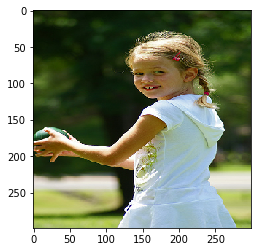

In [ ]:
test_id = 8
plt.imshow(get_image(train_list[test_id]))
image_decoder(enc_train[test_id])

['<START>', 'a', 'skateboarder', 'jumps', 'off', 'a', 'rail', '.', '<END>']

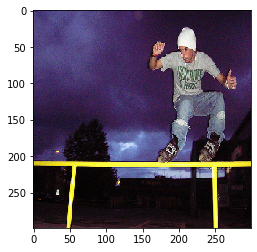

In [ ]:
plt.imshow(get_image(dev_list[45]))
image_decoder(enc_dev[45])

For this assignment we will not perform a formal evaluation. 

Feel free to experiment with the parameters of the model or continue training the model. At some point, the model will overfit and will no longer produce good descriptions for the dev images. 

Implement the beam search in the decoder. 
*beam*, which contains the n highest-scoring sequences so far and their total probability (i.e. the product of all word probabilities). Use a list of `(probability, sequence)` tuples. After each time-step, prune the list to include only the n most probable sequences. 

Then, for each sequence, compute the n most likely successor words. Append the word to produce n new sequences and compute their score. This way, you create a new list of n*n candidates. 

Prune this list to the best n as before and continue until `MAX_LEN` words have been generated. 



In [ ]:
import math

def img_beam_decoder(n, enc_image):
    next_word = "<START>"
    senten = [word_to_id["<START>"]]
    cur_id = 0
    cal_lst = [(0, senten)]
    next_lst = []
    while cur_id < MAX_LEN:
      while len(cal_lst)>0:
        score, senten = cal_lst.pop()
        input_txt = np.array(senten+[0]*(MAX_LEN-len(senten)))
        
        input = [np.array([enc_image]), np.array([input_txt])]
        output = model.predict(input)[0]
        idx_lst = np.argsort(output)[-n:]
        for idx in idx_lst:
          prob = output[idx]
          next_score = score+math.log2(prob)
          next_senten = senten+[idx]
          next_lst.append((next_score, next_senten))
        #print(next_lst)
      cal_lst = sorted(next_lst, key = lambda x: x[0])[-n:]
      #print(cal_lst)
      next_lst = []
      cur_id+=1
    #return cal_lst[-1] 
    return [id_to_word[item] for item in cal_lst[-1][1]]

In [ ]:
img_beam_decoder(3, enc_dev[1])

NameError: ignored

Tune differnet beam size
 

In [ ]:
test_id = 1
plt.imshow(get_image(dev_list[test_id]))
print(image_decoder(enc_dev[test_id]))
print(img_beam_decoder(3, enc_dev[test_id]))
print(img_beam_decoder(5, enc_dev[test_id]))

In [ ]:
test_id = 12
plt.imshow(get_image(dev_list[test_id]))
print(image_decoder(enc_dev[test_id]))
print(img_beam_decoder(3, enc_dev[test_id]))
print(img_beam_decoder(5, enc_dev[test_id]))

In [ ]:
test_id = 88
plt.imshow(get_image(dev_list[test_id]))
print(image_decoder(enc_dev[test_id]))
print(img_beam_decoder(3, enc_dev[test_id]))
print(img_beam_decoder(5, enc_dev[test_id]))

In [ ]:
test_id = 45
plt.imshow(get_image(dev_list[test_id]))
print(image_decoder(enc_dev[test_id]))
print(img_beam_decoder(3, enc_dev[test_id]))
print(img_beam_decoder(5, enc_dev[test_id]))

In [ ]:
test_id = 256
plt.imshow(get_image(dev_list[test_id]))
print(image_decoder(enc_dev[test_id]))
print(img_beam_decoder(3, enc_dev[test_id]))
print(img_beam_decoder(5, enc_dev[test_id]))